# Plotting biometric error plots
This notebook computes and plots the false accept rate (FAR) error rate of deduplication given the false positive (FP) and false negative (FN) rates of the sensor for a single biometric template. The deduplication may use a single template per user or fuse $f$ samples together. This notebook corresponds to the Section 7 (Biometrics in practice) of the paper.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style()

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('figure', figsize=(5.5,4))
plt.rc('text.latex', preamble=r'\usepackage{mathptmx}')

data_dir = '../data/'
fig_dir = '../figures/'

COLOR_PALETTE = ['#88CCEE','#CC6677','#DDCC77','#117733', '#332288', '#AA4499', '#44AA99']
PLT_MARKER = [6, 6, 7, 7]

## Single source error rates
Generate false acceptance rate error based on the number of registered users `user_sizes`, false positive rate of the sensor for each individual match `fp_rates_percent`, and the number of fused templates per user `fuse_num`.

In [3]:
def gen_far_data_single(user_sizes, fp_rates_percent, fuse_num=1):
    data = {}
    for fp in fp_rates_percent:
        line = "$P_{fp}$ = " + f"{fp}\%"
        if fuse_num > 1:
            line = "$f, P_{fp}$ = " +  f"{fuse_num}, {fp}\%"
        data[line] = {}
        for n in user_sizes:
            effective_fp = (fp/100.0)**fuse_num
            far = 1 - (1-effective_fp)**n
            data[line][n] = far

    df = pd.DataFrame(data)
    df.index.name = 'users'
    df = df.reset_index()
    return df

def gen_far_data(user_sizes, fp_rates_percent, fuse_nums):
    far_list = []
    for sn in fuse_nums:
        df = gen_far_data_single(user_sizes, fp_rates_percent, sn)
        df['sample_num'] = sn
        far_list.append(df)
    far_e = pd.concat(far_list)
    far_e_long = far_e.melt(id_vars=['users', 'sample_num'], var_name="Error rate").dropna()
    return far_e_long

Plot the probability of failure to register based on the matching FP when only using a single template per user. This figure corresponds to Fig 3 in the paper.

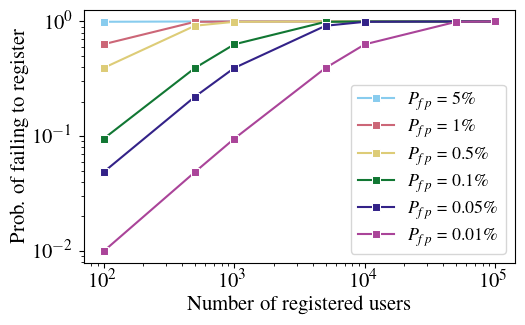

In [4]:
far_e_long = gen_far_data(
    user_sizes=[100, 500, 1000, 5000, 10000, 50000, 100000],
    fp_rates_percent=[5, 1, 0.5, 0.1, 0.05, 0.01], 
    fuse_nums=[1,2,3,4]
)
data = far_e_long.query('sample_num==1').loc[:]


fig, ax = plt.subplots(figsize=(5.5, 3.5))
sns.lineplot(data=data, x='users', y='value', hue='Error rate', palette=COLOR_PALETTE[:6], marker='s')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of registered users')
ax.set_ylabel("Prob. of failing to register")

plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig(fig_dir+"far.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show() 

Plot the probability of failure to register based on the matching FP when using $f$ template per user. This figure corresponds to Fig 4 in the paper.

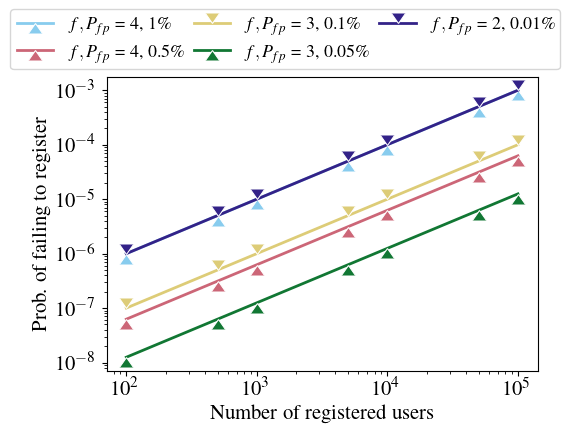

In [5]:
# generate the data for the fused template FAR experiment
user_sizes=[100, 500, 1000, 5000, 10000, 50000, 100000]
conf = [(1, 4), (0.5, 4), (0.1, 3), (0.05, 3), (0.01, 2)]
data = pd.concat([gen_far_data_single(user_sizes, [fp], n) for (fp, n) in  conf])
data = data.melt(id_vars=['users'], var_name="Samples").dropna()


fig, axes = plt.subplots(figsize=(5.5, 4.4))
ax = axes
sns.lineplot(data=data, x='users', y='value', hue='Samples', palette=COLOR_PALETTE[:5],
             style='Samples', dashes= False, markers=[6,6,7,6,7], linewidth=2, markersize=10)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of registered users')
ax.set_ylabel("Prob. of failing to register")

ax.legend(
    bbox_to_anchor=(0.00, 0.855, 1, 0), 
    loc='lower left',
    ncol=3, 
    mode="expand", 
    borderaxespad=0., 
    bbox_transform=fig.transFigure,
    fontsize=13,
)

plt.tight_layout()
plt.savefig(fig_dir+"far_multi.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show() 